# py-recipes: Comprehensive Feature Engineering Demo

This notebook demonstrates the complete capabilities of py-recipes, a feature engineering and preprocessing framework for py-tidymodels.

## Table of Contents

1. [Introduction](#introduction)
2. [Basic Recipe Operations](#basic)
3. [Time Series Features](#timeseries)
4. [Feature Selection](#selection)
5. [Mathematical Transformations](#transformations)
6. [Scaling and Centering](#scaling)
7. [Categorical Handling](#categorical)
8. [Missing Value Imputation](#imputation)
9. [Basis Functions](#basis)
10. [Feature Interactions](#interactions)
11. [Discretization](#discretization)
12. [Advanced Dimensionality Reduction](#reduction)
13. [Selectors](#selectors)
14. [Role Management](#roles)
15. [Workflow Integration](#workflows)
16. [Real-World Example](#realworld)

<a id='introduction'></a>
## 1. Introduction

py-recipes provides a consistent interface for feature engineering that:
- **Prevents data leakage**: Parameters are fit on training data only
- **Ensures reproducibility**: Same transformations apply to new data
- **Enables composability**: Chain multiple preprocessing steps
- **Integrates seamlessly**: Works with py-workflows and py-parsnip

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from py_recipes import recipe
from py_recipes.selectors import all_numeric, all_nominal, starts_with, ends_with
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

<a id='basic'></a>
## 2. Basic Recipe Operations

Recipes use a two-phase approach:
1. **prep()**: Fit preprocessing parameters on training data
2. **bake()**: Apply transformations to any data (train or test)

In [2]:
# Create sample data
train = pd.DataFrame({
    'age': [25, 35, 45, 55, 65],
    'income': [30000, 50000, 70000, 90000, 110000],
    'category': ['A', 'B', 'A', 'C', 'B'],
    'outcome': [0, 1, 0, 1, 1]
})

test = pd.DataFrame({
    'age': [30, 40],
    'income': [40000, 60000],
    'category': ['A', 'B'],
    'outcome': [0, 1]
})

print("Training data:")
print(train)

Training data:
   age  income category  outcome
0   25   30000        A        0
1   35   50000        B        1
2   45   70000        A        0
3   55   90000        C        1
4   65  110000        B        1


In [3]:
# Create a simple recipe
rec = (
    recipe()
    .step_normalize()  # Normalize numeric columns
    .step_dummy(['category'])  # Create dummy variables
)

# Fit on training data
rec_fit = rec.prep(train)

# Apply to training data
train_processed = rec_fit.bake(train)
print("\nProcessed training data:")
print(train_processed)

# Apply to test data (using training parameters!)
test_processed = rec_fit.bake(test)
print("\nProcessed test data:")
print(test_processed)


Processed training data:
        age    income   outcome  category_A  category_B  category_C
0 -1.414214 -1.414214 -1.224745         1.0         0.0         0.0
1 -0.707107 -0.707107  0.816497         0.0         1.0         0.0
2  0.000000  0.000000 -1.224745         1.0         0.0         0.0
3  0.707107  0.707107  0.816497         0.0         0.0         1.0
4  1.414214  1.414214  0.816497         0.0         1.0         0.0

Processed test data:
        age    income   outcome  category_A  category_B  category_C
0 -1.060660 -1.060660 -1.224745         1.0         0.0         0.0
1 -0.353553 -0.353553  0.816497         0.0         1.0         0.0


<a id='timeseries'></a>
## 3. Time Series Features

py-recipes includes comprehensive time series feature engineering with pytimetk integration.

In [4]:
# Create time series data
dates = pd.date_range('2024-01-01', periods=100, freq='D')
ts_data = pd.DataFrame({
    'date': dates,
    'sales': np.cumsum(np.random.randn(100)) + 100,
    'price': 10 + np.random.randn(100) * 2
})

print("Time series data:")
print(ts_data.head())

Time series data:
        date       sales     price
0 2024-01-01  100.496714  7.169259
1 2024-01-02  100.358450  9.158709
2 2024-01-03  101.006138  9.314571
3 2024-01-04  102.529168  8.395445
4 2024-01-05  102.295015  9.677429


In [5]:
# Create lag features
ts_rec = (
    recipe()
    .step_lag(['sales'], lags=[1, 7, 14])  # 1-day, 1-week, 2-week lags
    .step_rolling(['sales'], window=7, stats=['mean', 'std'])  # 7-day rolling stats
    .step_diff(['sales'], differences=1)  # First difference
    .step_pct_change(['sales'], periods=1)  # Percent change
)

ts_rec_fit = ts_rec.prep(ts_data)
ts_processed = ts_rec_fit.bake(ts_data)

print("\nTime series features:")
print(ts_processed.columns.tolist())
print(ts_processed.tail())


Time series features:
['date', 'sales', 'price', 'sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_rolling_7_mean', 'sales_rolling_7_std', 'sales_diff_1', 'sales_pct_change_1']
         date      sales      price  sales_lag_1  sales_lag_7  sales_lag_14  \
95 2024-04-05  89.287646  10.770635    90.751161    90.593995     90.230229   
96 2024-04-06  89.583767   8.232285    89.287646    91.107262     91.708123   
97 2024-04-07  89.844822  10.307450    89.583767    91.204340     91.189852   
98 2024-04-08  89.849935  10.116417    89.844822    92.172985     90.381359   
99 2024-04-09  89.615348   7.714059    89.849935    91.470932     89.879602   

    sales_rolling_7_mean  sales_rolling_7_std  sales_diff_1  \
95             91.019657             0.881554     -1.463515   
96             90.802014             1.031613      0.296120   
97             90.607797             1.070488      0.261055   
98             90.275933             0.839570      0.005113   
99             90.010850     

In [6]:
# Date feature extraction
date_rec = (
    recipe()
    .step_date(
        column='date',
        features=['year', 'month', 'day', 'dayofweek', 'quarter']
    )
)

date_rec_fit = date_rec.prep(ts_data)
date_features = date_rec_fit.bake(ts_data)

print("\nDate features created:")
print("Columns:", date_features.columns.tolist())
print("\nFirst few rows:")
print(date_features.head())


Date features created:
Columns: ['date', 'sales', 'price', 'date_year', 'date_month', 'date_day', 'date_dayofweek', 'date_quarter']

First few rows:
        date       sales     price  date_year  date_month  date_day  \
0 2024-01-01  100.496714  7.169259       2024           1         1   
1 2024-01-02  100.358450  9.158709       2024           1         2   
2 2024-01-03  101.006138  9.314571       2024           1         3   
3 2024-01-04  102.529168  8.395445       2024           1         4   
4 2024-01-05  102.295015  9.677429       2024           1         5   

   date_dayofweek  date_quarter  
0               0             1  
1               1             1  
2               2             1  
3               3             1  
4               4             1  


In [7]:
# Exponentially weighted moving average
ewm_rec = (
    recipe()
    .step_ewm(['sales'], span=7, statistics=['mean', 'std'])
)

ewm_rec_fit = ewm_rec.prep(ts_data)
ewm_features = ewm_rec_fit.bake(ts_data)

print("\nEWM features:")
print(ewm_features[['sales', 'ewm_sales_mean_7', 'ewm_sales_std_7']].tail())


EWM features:
        sales  ewm_sales_mean_7  ewm_sales_std_7
95  89.287646         90.672097         0.983090
96  89.583767         90.400014         0.991943
97  89.844822         90.261216         0.897435
98  89.849935         90.158396         0.800652
99  89.615348         90.022634         0.738439


<a id='selection'></a>
## 4. Feature Selection

py-recipes provides multiple feature selection methods from basic (PCA, correlation) to advanced (VIP, Boruta, RFE).

In [8]:
# Create data with relevant and irrelevant features
n = 200
x1 = np.random.randn(n)
x2 = np.random.randn(n)
x3 = np.random.randn(n)
noise1 = np.random.randn(n)
noise2 = np.random.randn(n)
noise3 = np.random.randn(n)

y = 2 * x1 + 3 * x2 - 1.5 * x3 + np.random.randn(n) * 0.5

feature_data = pd.DataFrame({
    'x1': x1, 'x2': x2, 'x3': x3,
    'noise1': noise1, 'noise2': noise2, 'noise3': noise3,
    'y': y
})

print("Feature selection data:")
print(feature_data.head())
print(f"\nShape: {feature_data.shape}")

Feature selection data:
         x1        x2        x3    noise1    noise2    noise3         y
0  0.357787 -1.594428  0.756989  0.938284  1.399355  0.125225 -5.726647
1  0.560785 -0.599375 -0.922165 -0.516045  0.924634 -0.429406  0.975018
2  1.083051  0.005244  0.869606  0.096121  0.059630  0.122298  1.470277
3  1.053802  0.046981  1.355638 -0.462275 -0.646937  0.543298  0.574566
4 -1.377669 -0.450065  0.413435 -0.434496  0.698223  0.048860 -4.227664

Shape: (200, 7)


In [9]:
# PCA-based feature selection
pca_rec = (
    recipe()
    .step_normalize()  # PCA requires normalized data
    .step_pca(num_comp=3)  # Reduce to 3 principal components
)

pca_rec_fit = pca_rec.prep(feature_data)
pca_features = pca_rec_fit.bake(feature_data)

print("\nPCA features:")
print(pca_features.columns.tolist())
print(pca_features.head())


PCA features:
['PC1', 'PC2', 'PC3']
        PC1       PC2       PC3
0 -2.095470 -0.178256  1.089601
1  0.393537 -1.276586  0.773848
2  0.534479  0.209504 -0.056949
3  0.470902  0.289760 -1.113028
4 -1.602878  0.148905 -0.255028


In [10]:
# Correlation-based feature selection
corr_rec = (
    recipe()
    .step_select_corr(outcome='y', threshold=0.9, method='multicollinearity')  # Remove highly correlated
)

corr_rec_fit = corr_rec.prep(feature_data)
corr_features = corr_rec_fit.bake(feature_data)

print("\nCorrelation filtering:")
print(f"Original columns: {feature_data.shape[1]}")
print(f"After filtering: {corr_features.shape[1]}")
print(corr_features.columns.tolist())


Correlation filtering:
Original columns: 7
After filtering: 7
['x1', 'x2', 'x3', 'noise1', 'noise2', 'noise3', 'y']


In [11]:
# VIP (Variable Importance in Projection)
vip_rec = (
    recipe()
    .step_vip(outcome='y', threshold=1.0, num_comp=2)
)

vip_rec_fit = vip_rec.prep(feature_data)
vip_features = vip_rec_fit.bake(feature_data)

print("\nVIP feature selection:")
print(f"Selected features: {vip_features.columns.tolist()}")

# Access VIP scores
vip_scores = vip_rec_fit.prepared_steps[0].vip_scores
print("\nVIP scores:")
for feature, score in sorted(vip_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {score:.3f}")


VIP feature selection:
Selected features: ['x2', 'noise1', 'y']

VIP scores:
x2: 1.349
noise1: 1.277
x1: 0.990
noise3: 0.763
noise2: 0.746
x3: 0.657


In [12]:
# Recursive Feature Elimination (RFE)
rfe_rec = (
    recipe()
    .step_rfe(outcome='y', n_features=3)
)

rfe_rec_fit = rfe_rec.prep(feature_data)
rfe_features = rfe_rec_fit.bake(feature_data)

print("\nRFE feature selection:")
print(f"Selected features: {rfe_features.columns.tolist()}")

# Access feature rankings
feature_ranks = rfe_rec_fit.prepared_steps[0].feature_ranks
print("\nFeature rankings (1=best):")
for feature, rank in sorted(feature_ranks.items(), key=lambda x: x[1]):
    print(f"{feature}: {rank}")


RFE feature selection:
Selected features: ['x1', 'x2', 'x3', 'y']

Feature rankings (1=best):
x1: 1
x2: 1
x3: 1
noise1: 2
noise2: 3
noise3: 4


In [13]:
# Boruta all-relevant feature selection
boruta_rec = (
    recipe()
    .step_boruta(outcome='y', max_iter=50, random_state=42)
)

boruta_rec_fit = boruta_rec.prep(feature_data)
boruta_features = boruta_rec_fit.bake(feature_data)

print("\nBoruta feature selection:")
print(f"Selected features: {boruta_features.columns.tolist()}")


Boruta feature selection:
Selected features: ['x1', 'x2', 'y']


<a id='transformations'></a>
## 5. Mathematical Transformations

Transform skewed distributions to be more normal.

In [14]:
# Create skewed data
skewed_data = pd.DataFrame({
    'skewed1': np.exp(np.random.randn(100)),  # Log-normal
    'skewed2': np.random.chisquare(2, 100),  # Chi-square
    'normal': np.random.randn(100)
})

print("Skewed data statistics:")
print(skewed_data.describe())

Skewed data statistics:
          skewed1     skewed2      normal
count  100.000000  100.000000  100.000000
mean     1.971528    2.040331   -0.110203
std      2.968085    1.846977    0.945503
min      0.119809    0.024963   -2.151815
25%      0.626768    0.660207   -0.752016
50%      1.095073    1.613069   -0.113563
75%      2.397109    2.922410    0.549379
max     24.364023   10.779776    1.901191


In [15]:
# Log transformation
log_rec = (
    recipe()
    .step_log(['skewed1', 'skewed2'])
)

log_rec_fit = log_rec.prep(skewed_data)
log_transformed = log_rec_fit.bake(skewed_data)

print("\nAfter log transformation:")
print(log_transformed.describe())


After log transformation:
          skewed1     skewed2      normal
count  100.000000  100.000000  100.000000
mean     0.164968    0.185594   -0.110203
std      0.951689    1.231646    0.945503
min     -2.121855   -3.690352   -2.151815
25%     -0.467189   -0.415206   -0.752016
50%      0.090563    0.477955   -0.113563
75%      0.874250    1.072358    0.549379
max      3.193108    2.377672    1.901191


In [16]:
# Box-Cox transformation (automatic lambda selection)
boxcox_rec = (
    recipe()
    .step_boxcox(['skewed1', 'skewed2'])
)

boxcox_rec_fit = boxcox_rec.prep(skewed_data)
boxcox_transformed = boxcox_rec_fit.bake(skewed_data)

print("\nAfter Box-Cox transformation:")
print(boxcox_transformed.describe())


After Box-Cox transformation:
          skewed1     skewed2      normal
count  100.000000  100.000000  100.000000
mean     0.093106    0.423766   -0.110203
std      0.910906    1.195319    0.945503
min     -2.533214   -2.168931   -2.151815
25%     -0.485367   -0.388885   -0.752016
50%      0.089859    0.516382   -0.113563
75%      0.815034    1.278616    0.549379
max      2.491649    3.557962    1.901191


In [17]:
# Yeo-Johnson transformation (handles negative values)
mixed_data = pd.DataFrame({
    'mixed': np.concatenate([np.random.randn(50) - 2, np.random.randn(50) + 2])
})

yj_rec = (
    recipe()
    .step_yeojohnson(['mixed'])
)

yj_rec_fit = yj_rec.prep(mixed_data)
yj_transformed = yj_rec_fit.bake(mixed_data)

print("\nYeo-Johnson transformation:")
print(f"Original skewness: {mixed_data['mixed'].skew():.3f}")
print(f"Transformed skewness: {yj_transformed['mixed'].skew():.3f}")


Yeo-Johnson transformation:
Original skewness: -0.004
Transformed skewness: -0.005


<a id='scaling'></a>
## 6. Scaling and Centering

Standardize features to have similar scales.

In [18]:
# Data with different scales
scale_data = pd.DataFrame({
    'small': np.random.randn(100) * 0.1,
    'medium': np.random.randn(100),
    'large': np.random.randn(100) * 100
})

print("Original data:")
print(scale_data.describe())

Original data:
            small      medium       large
count  100.000000  100.000000  100.000000
mean    -0.003091   -0.044208   -4.172571
std      0.093412    0.970619   99.982178
min     -0.301951   -2.562334 -260.421386
25%     -0.064564   -0.815267  -65.252532
50%     -0.000455   -0.009366   -3.911078
75%      0.067151    0.601702   66.957770
max      0.275966    2.412615  209.972179


In [19]:
# Center (mean = 0)
center_rec = recipe().step_center()
center_rec_fit = center_rec.prep(scale_data)
centered = center_rec_fit.bake(scale_data)

print("\nCentered data (mean = 0):")
print(centered.mean())


Centered data (mean = 0):
small    -6.938894e-19
medium   -2.525757e-17
large    -4.405365e-15
dtype: float64


In [20]:
# Scale (std = 1)
scale_rec = recipe().step_scale()
scale_rec_fit = scale_rec.prep(scale_data)
scaled = scale_rec_fit.bake(scale_data)

print("\nScaled data (std = 1):")
print(scaled.std())


Scaled data (std = 1):
small     1.0
medium    1.0
large     1.0
dtype: float64


In [21]:
# Normalize (Z-score: mean=0, std=1)
normalize_rec = recipe().step_normalize()
normalize_rec_fit = normalize_rec.prep(scale_data)
normalized = normalize_rec_fit.bake(scale_data)

print("\nNormalized data:")
print("Means:", normalized.mean().values)
print("Stds:", normalized.std().values)


Normalized data:
Means: [-2.66453526e-17 -2.51881849e-17 -3.44169138e-17]
Stds: [1.00503782 1.00503782 1.00503782]


In [22]:
# Range scaling (min-max to [0, 1])
range_rec = recipe().step_range(min_val=0, max_val=1)
range_rec_fit = range_rec.prep(scale_data)
ranged = range_rec_fit.bake(scale_data)

print("\nRange scaled to [0, 1]:")
print(ranged.describe())


Range scaled to [0, 1]:
            small      medium       large
count  100.000000  100.000000  100.000000
mean     0.517133    0.506161    0.544754
std      0.161635    0.195101    0.212550
min      0.000000    0.000000    0.000000
25%      0.410763    0.351173    0.414905
50%      0.521695    0.513165    0.545310
75%      0.638677    0.635994    0.695969
max      1.000000    1.000000    1.000000


<a id='categorical'></a>
## 7. Categorical Handling

Handle categorical variables with multiple encoding strategies.

In [23]:
# Categorical data
cat_data = pd.DataFrame({
    'category': ['A', 'B', 'C', 'A', 'B', 'rare1', 'rare2', 'A', 'B', 'C'],
    'value': np.random.randn(10)
})

print("Categorical data:")
print(cat_data['category'].value_counts())

Categorical data:
category
A        3
B        3
C        2
rare1    1
rare2    1
Name: count, dtype: int64


In [24]:
# One-hot encoding (dummy variables)
dummy_rec = recipe().step_dummy(['category'])
dummy_rec_fit = dummy_rec.prep(cat_data)
dummied = dummy_rec_fit.bake(cat_data)

print("\nOne-hot encoded:")
print(dummied.head())


One-hot encoded:
      value  category_A  category_B  category_C  category_rare1  \
0 -1.725807         1.0         0.0         0.0             0.0   
1 -0.677565         0.0         1.0         0.0             0.0   
2  1.194109         0.0         0.0         1.0             0.0   
3 -0.981166         1.0         0.0         0.0             0.0   
4 -0.464404         0.0         1.0         0.0             0.0   

   category_rare2  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  


In [25]:
# Integer encoding
integer_rec = recipe().step_integer(['category'])
integer_rec_fit = integer_rec.prep(cat_data)
integer_encoded = integer_rec_fit.bake(cat_data)

print("\nInteger encoded:")
print(integer_encoded)


Integer encoded:
   category     value
0         0 -1.725807
1         1 -0.677565
2         2  1.194109
3         0 -0.981166
4         1 -0.464404
5         3  0.462061
6         4  0.783391
7         0 -0.251539
8         1 -0.597510
9         2  1.422370


In [26]:
# Pool rare categories into 'other'
other_rec = recipe().step_other(['category'], threshold=0.15)  # <15% frequency
other_rec_fit = other_rec.prep(cat_data)
other_pooled = other_rec_fit.bake(cat_data)

print("\nRare categories pooled:")
print(other_pooled['category'].value_counts())


Rare categories pooled:
category
A        3
B        3
C        2
other    2
Name: count, dtype: int64


In [27]:
# Handle novel categories in test data
train_cat = pd.DataFrame({'cat': ['A', 'B', 'C', 'A', 'B']})
test_cat = pd.DataFrame({'cat': ['A', 'D', 'E']})  # D and E are novel

novel_rec = recipe().step_novel(['cat'])
novel_rec_fit = novel_rec.prep(train_cat)
test_handled = novel_rec_fit.bake(test_cat)

print("\nNovel categories handled:")
print(test_handled)


Novel categories handled:
   cat
0    A
1  new
2  new


<a id='imputation'></a>
## 8. Missing Value Imputation

Handle missing values with various imputation strategies.

In [28]:
# Data with missing values
missing_data = pd.DataFrame({
    'x1': [1, 2, np.nan, 4, 5, np.nan, 7, 8, 9, 10],
    'x2': [10, np.nan, 30, 40, np.nan, 60, 70, 80, 90, 100],
    'x3': [1.1, 2.2, 3.3, np.nan, 5.5, 6.6, np.nan, 8.8, 9.9, 10.0]
})

print("Missing data:")
print(missing_data)
print(f"\nMissing values:\n{missing_data.isna().sum()}")

Missing data:
     x1     x2    x3
0   1.0   10.0   1.1
1   2.0    NaN   2.2
2   NaN   30.0   3.3
3   4.0   40.0   NaN
4   5.0    NaN   5.5
5   NaN   60.0   6.6
6   7.0   70.0   NaN
7   8.0   80.0   8.8
8   9.0   90.0   9.9
9  10.0  100.0  10.0

Missing values:
x1    2
x2    2
x3    2
dtype: int64


In [29]:
# Mean imputation
mean_rec = recipe().step_impute_mean()
mean_rec_fit = mean_rec.prep(missing_data)
mean_imputed = mean_rec_fit.bake(missing_data)

print("\nMean imputation:")
print(mean_imputed)
print(f"\nRemaining missing: {mean_imputed.isna().sum().sum()}")


Mean imputation:
      x1     x2      x3
0   1.00   10.0   1.100
1   2.00   60.0   2.200
2   5.75   30.0   3.300
3   4.00   40.0   5.925
4   5.00   60.0   5.500
5   5.75   60.0   6.600
6   7.00   70.0   5.925
7   8.00   80.0   8.800
8   9.00   90.0   9.900
9  10.00  100.0  10.000

Remaining missing: 0


In [30]:
# Median imputation (robust to outliers)
median_rec = recipe().step_impute_median()
median_rec_fit = median_rec.prep(missing_data)
median_imputed = median_rec_fit.bake(missing_data)

print("\nMedian imputation:")
print(median_imputed)


Median imputation:
     x1     x2     x3
0   1.0   10.0   1.10
1   2.0   65.0   2.20
2   6.0   30.0   3.30
3   4.0   40.0   6.05
4   5.0   65.0   5.50
5   6.0   60.0   6.60
6   7.0   70.0   6.05
7   8.0   80.0   8.80
8   9.0   90.0   9.90
9  10.0  100.0  10.00


In [31]:
# KNN imputation (uses neighbors)
knn_rec = recipe().step_impute_knn(neighbors=3)
knn_rec_fit = knn_rec.prep(missing_data)
knn_imputed = knn_rec_fit.bake(missing_data)

print("\nKNN imputation:")
print(knn_imputed)


KNN imputation:
          x1          x2         x3
0   1.000000   10.000000   1.100000
1   2.000000   26.666667   2.200000
2   3.666667   30.000000   3.300000
3   4.000000   40.000000   3.666667
4   5.000000   56.666667   5.500000
5   4.666667   60.000000   6.600000
6   7.000000   70.000000   5.500000
7   8.000000   80.000000   8.800000
8   9.000000   90.000000   9.900000
9  10.000000  100.000000  10.000000


In [32]:
# Indicate missing values before imputation
indicate_rec = (
    recipe()
    .step_indicate_na()  # Create NA indicators
    .step_impute_mean()  # Then impute
)

indicate_rec_fit = indicate_rec.prep(missing_data)
indicated = indicate_rec_fit.bake(missing_data)

print("\nNA indicators + imputation:")
print(indicated.head())


NA indicators + imputation:
     x1    x2     x3  na_ind_x1  na_ind_x2  na_ind_x3
0  1.00  10.0  1.100          0          0          0
1  2.00  60.0  2.200          0          1          0
2  5.75  30.0  3.300          1          0          0
3  4.00  40.0  5.925          0          0          1
4  5.00  60.0  5.500          0          1          0


<a id='basis'></a>
## 9. Basis Functions

Create non-linear features for capturing complex relationships.

In [33]:
# Linear data
basis_data = pd.DataFrame({
    'x': np.linspace(0, 10, 50),
    'time': np.arange(50)
})

print("Basis function data:")
print(basis_data.head())

Basis function data:
          x  time
0  0.000000     0
1  0.204082     1
2  0.408163     2
3  0.612245     3
4  0.816327     4


In [34]:
# Polynomial features
poly_rec = recipe().step_poly(columns=['x'], degree=3)
poly_rec_fit = poly_rec.prep(basis_data)
poly_features = poly_rec_fit.bake(basis_data)

print("\nPolynomial features:")
print([col for col in poly_features.columns if 'x' in col])
print(poly_features.head())


Polynomial features:
['x^2', 'x^3']
   time       x^2       x^3
0     0  0.000000  0.000000
1     1  0.041649  0.008500
2     2  0.166597  0.067999
3     3  0.374844  0.229496
4     4  0.666389  0.543991


In [35]:
# B-spline basis
bs_rec = recipe().step_bs(column='x', degree=3, df=5)
bs_rec_fit = bs_rec.prep(basis_data)
bs_features = bs_rec_fit.bake(basis_data)

print("\nB-spline features:")
print([col for col in bs_features.columns if 'bs' in col])
print(f"Created {len([c for c in bs_features.columns if 'bs' in c])} basis functions")


B-spline features:
['x_bs_1', 'x_bs_2', 'x_bs_3', 'x_bs_4', 'x_bs_5']
Created 5 basis functions


In [36]:
# Natural spline
ns_rec = recipe().step_ns(column='x', df=4)
ns_rec_fit = ns_rec.prep(basis_data)
ns_features = ns_rec_fit.bake(basis_data)

print("\nNatural spline features:")
print([col for col in ns_features.columns if 'ns' in col])


Natural spline features:
['x_ns_1', 'x_ns_2', 'x_ns_3', 'x_ns_4']


In [37]:
# Harmonic (Fourier) features for seasonality
harmonic_rec = recipe().step_harmonic(column='time', frequency=1, period=24)
harmonic_rec_fit = harmonic_rec.prep(basis_data)
harmonic_features = harmonic_rec_fit.bake(basis_data)

print("\nHarmonic features (seasonal):")
print([col for col in harmonic_features.columns if 'sin' in col or 'cos' in col])
print(harmonic_features[['time', 'time_sin_1', 'time_cos_1']].head())


Harmonic features (seasonal):
['time_sin_1', 'time_cos_1']
   time  time_sin_1  time_cos_1
0     0    0.000000    1.000000
1     1    0.258819    0.965926
2     2    0.500000    0.866025
3     3    0.707107    0.707107
4     4    0.866025    0.500000


<a id='interactions'></a>
## 10. Feature Interactions

Create interaction terms between features.

In [38]:
# Data for interactions
interact_data = pd.DataFrame({
    'price': [10, 20, 30, 40, 50],
    'quantity': [100, 80, 60, 40, 20],
    'discount': [0, 0.1, 0.2, 0.3, 0.4]
})

print("Interaction data:")
print(interact_data)

Interaction data:
   price  quantity  discount
0     10       100       0.0
1     20        80       0.1
2     30        60       0.2
3     40        40       0.3
4     50        20       0.4


In [39]:
# Multiplicative interactions
interact_rec = (
    recipe()
    .step_interact([('price', 'quantity'), ('price', 'discount')])
)

interact_rec_fit = interact_rec.prep(interact_data)
interacted = interact_rec_fit.bake(interact_data)

print("\nWith interactions:")
print(interacted)


With interactions:
   price  quantity  discount  price_x_quantity  price_x_discount
0     10       100       0.0              1000               0.0
1     20        80       0.1              1600               2.0
2     30        60       0.2              1800               6.0
3     40        40       0.3              1600              12.0
4     50        20       0.4              1000              20.0


In [40]:
# Ratio features
ratio_rec = (
    recipe()
    .step_ratio([('price', 'quantity'), ('discount', 'price')])
)

ratio_rec_fit = ratio_rec.prep(interact_data)
ratioed = ratio_rec_fit.bake(interact_data)

print("\nWith ratios:")
print(ratioed)


With ratios:
   price  quantity  discount  price_per_quantity  discount_per_price
0     10       100       0.0                0.10            0.000000
1     20        80       0.1                0.25            0.005000
2     30        60       0.2                0.50            0.006667
3     40        40       0.3                1.00            0.007500
4     50        20       0.4                2.50            0.008000


<a id='discretization'></a>
## 11. Discretization

Bin continuous variables into discrete categories.

In [41]:
# Continuous data
disc_data = pd.DataFrame({
    'age': np.random.randint(18, 80, 100),
    'income': np.random.randint(20000, 150000, 100)
})

print("Continuous data:")
print(disc_data.describe())

Continuous data:
              age         income
count  100.000000     100.000000
mean    48.910000   89461.740000
std     18.796139   40533.904637
min     18.000000   20112.000000
25%     33.750000   50801.000000
50%     49.000000   99637.500000
75%     66.000000  125156.000000
max     79.000000  147815.000000


In [42]:
# Discretize into quantile-based bins
discretize_rec = recipe().step_discretize(['age'], num_breaks=5, labels=None)
discretize_rec_fit = discretize_rec.prep(disc_data)
discretized = discretize_rec_fit.bake(disc_data)

print("\nDiscretized age:")
print(discretized['age'].value_counts().sort_index())


Discretized age:
age
bin_1    20
bin_2    20
bin_3    20
bin_4    22
bin_5    18
Name: count, dtype: int64


In [43]:
# Cut at specific thresholds
cut_rec = recipe().step_cut(['age'], breaks=[0, 30, 50, 100], labels=['young', 'middle', 'senior'])
cut_rec_fit = cut_rec.prep(disc_data)
cut_data = cut_rec_fit.bake(disc_data)

print("\nAge categories:")
print(cut_data['age'].value_counts())


Age categories:
age
76    6
34    6
49    5
66    4
69    3
18    3
21    3
51    3
23    3
72    3
64    3
56    2
42    2
32    2
57    2
75    2
20    2
41    2
58    2
53    2
78    2
38    2
65    2
74    2
26    2
79    2
27    2
31    2
46    2
43    1
62    1
37    1
29    1
35    1
36    1
60    1
70    1
52    1
68    1
30    1
40    1
19    1
25    1
55    1
54    1
39    1
28    1
59    1
48    1
33    1
50    1
Name: count, dtype: int64


<a id='reduction'></a>
## 12. Advanced Dimensionality Reduction

Reduce feature dimensions with advanced techniques.

In [44]:
# High-dimensional data
n_samples = 100
n_features = 20
high_dim = pd.DataFrame(
    np.random.randn(n_samples, n_features),
    columns=[f'feature_{i}' for i in range(n_features)]
)
high_dim['outcome'] = np.random.randn(n_samples)

print(f"High-dimensional data: {high_dim.shape}")

High-dimensional data: (100, 21)


In [45]:
# Independent Component Analysis (ICA)
ica_rec = recipe().step_ica(num_comp=5)
ica_rec_fit = ica_rec.prep(high_dim)
ica_reduced = ica_rec_fit.bake(high_dim)

print("\nICA reduction:")
print(f"Original: {high_dim.shape}, Reduced: {ica_reduced.shape}")
print(ica_reduced.columns.tolist())


ICA reduction:
Original: (100, 21), Reduced: (100, 5)
['IC1', 'IC2', 'IC3', 'IC4', 'IC5']


In [46]:
# Kernel PCA (non-linear reduction)
kpca_rec = recipe().step_kpca(num_comp=5, kernel='rbf')
kpca_rec_fit = kpca_rec.prep(high_dim)
kpca_reduced = kpca_rec_fit.bake(high_dim)

print("\nKernel PCA reduction:")
print(f"Shape: {kpca_reduced.shape}")
print(kpca_reduced.columns.tolist())


Kernel PCA reduction:
Shape: (100, 5)
['KPC1', 'KPC2', 'KPC3', 'KPC4', 'KPC5']


In [47]:
# Partial Least Squares (supervised reduction)
pls_rec = recipe().step_pls(outcome='outcome', num_comp=3)
pls_rec_fit = pls_rec.prep(high_dim)
pls_reduced = pls_rec_fit.bake(high_dim)

print("\nPLS reduction:")
print(f"Shape: {pls_reduced.shape}")
print(pls_reduced.columns.tolist())


PLS reduction:
Shape: (100, 4)
['outcome', 'PLS1', 'PLS2', 'PLS3']


<a id='selectors'></a>
## 13. Selectors

Flexible column selection with tidyselect-style helpers.

In [48]:
# Import additional selectors
from py_recipes.selectors import (
    contains, matches, one_of, everything,
    union, intersection, difference
)

# Sample data with various column types
selector_data = pd.DataFrame({
    'age': [25, 35, 45],
    'age_squared': [625, 1225, 2025],
    'income': [30000, 50000, 70000],
    'income_log': [10.31, 10.82, 11.16],
    'category': ['A', 'B', 'C'],
    'outcome': [0, 1, 0]
})

print("Selector data columns:")
print(selector_data.columns.tolist())

Selector data columns:
['age', 'age_squared', 'income', 'income_log', 'category', 'outcome']


In [49]:
# Select by type
numeric_rec = (
    recipe()
    .step_normalize(columns=all_numeric())
)

print("\nSelecting all numeric columns for normalization...")


Selecting all numeric columns for normalization...


In [50]:
# Select by pattern
print("\nPattern-based selection:")
print(f"starts_with('age'): {starts_with('age')(selector_data)}")
print(f"ends_with('log'): {ends_with('log')(selector_data)}")
print(f"contains('come'): {contains('come')(selector_data)}")


Pattern-based selection:
starts_with('age'): ['age', 'age_squared']
ends_with('log'): ['income_log']
contains('come'): ['income', 'income_log', 'outcome']


In [51]:
# Combine selectors
combined_selector = union(
    starts_with('age'),
    ends_with('log')
)

print("\nUnion of starts_with('age') and ends_with('log'):")
print(combined_selector(selector_data))


Union of starts_with('age') and ends_with('log'):
['age', 'age_squared', 'income_log']


In [52]:
# Exclude columns
diff_selector = difference(
    all_numeric(),
    one_of('outcome')
)

print("\nAll numeric except outcome:")
print(diff_selector(selector_data))


All numeric except outcome:
['age', 'age_squared', 'income', 'income_log']


<a id='roles'></a>
## 14. Role Management

Track and manage column roles (predictor, outcome, ID, etc.).

In [53]:
# Create recipe and assign roles
role_data = pd.DataFrame({
    'id': [1, 2, 3, 4, 5],
    'date': pd.date_range('2024-01-01', periods=5),
    'feature1': [10, 20, 30, 40, 50],
    'feature2': [1.1, 2.2, 3.3, 4.4, 5.5],
    'target': [0, 1, 0, 1, 1]
})

role_rec = recipe()

# Update roles
role_rec = role_rec.update_role(['id'], 'ID')
role_rec = role_rec.update_role(['target'], 'outcome')
role_rec = role_rec.update_role(['feature1', 'feature2'], 'predictor')
role_rec = role_rec.update_role(['date'], 'time_index')

print("Role assignments:")
print(role_rec.roles)

Role assignments:
{'ID': ['id'], 'outcome': ['target'], 'predictor': ['feature1', 'feature2'], 'time_index': ['date']}


In [54]:
# Query by role
predictors = role_rec.has_role(role='predictor')
outcome = role_rec.has_role(role='outcome')

print("\nPredictors:", predictors)
print("Outcome:", outcome)


Predictors: ['feature1', 'feature2']
Outcome: ['target']


In [55]:
# Add role without removing existing
role_rec = role_rec.add_role(['feature1'], 'important')

print("\nRoles after adding 'important' to feature1:")
print(role_rec.roles)


Roles after adding 'important' to feature1:
{'ID': ['id'], 'outcome': ['target'], 'predictor': ['feature1', 'feature2'], 'time_index': ['date'], 'important': ['feature1']}


<a id='workflows'></a>
## 15. Workflow Integration

Integrate recipes with py-workflows for complete modeling pipelines.

In [56]:
# Import workflow components
from py_workflows import workflow
from py_parsnip import linear_reg

# Create workflow data
wf_train = pd.DataFrame({
    'x1': np.random.randn(100),
    'x2': np.random.randn(100),
    'category': np.random.choice(['A', 'B', 'C'], 100),
    'y': np.random.randn(100)
})

wf_test = pd.DataFrame({
    'x1': np.random.randn(20),
    'x2': np.random.randn(20),
    'category': np.random.choice(['A', 'B', 'C'], 20),
    'y': np.random.randn(20)
})

print("Workflow data created")

Workflow data created


In [57]:
# Create preprocessing recipe
preprocessing = (
    recipe()
    .step_dummy(['category'])  # Encode categorical
    .step_normalize()  # Normalize numeric
)

# Create workflow
wf = (
    workflow()
    .add_recipe(preprocessing)
    .add_model(linear_reg().set_engine('sklearn'))
)

print("Workflow created with recipe + model")

Workflow created with recipe + model


In [58]:
# Fit workflow
wf_fit = wf.fit(wf_train)

print("\nWorkflow fitted on training data")
print("Recipe steps were applied, then model was fitted")


Workflow fitted on training data
Recipe steps were applied, then model was fitted


In [59]:
# Predict (recipe is applied automatically!)
predictions = wf_fit.predict(wf_test)

print("\nPredictions on test data:")
print(predictions.head())
print(f"\nTest data was automatically preprocessed using training parameters!")


Predictions on test data:
      .pred
0  0.060382
1  0.168912
2  0.015491
3 -0.177198
4  0.082618

Test data was automatically preprocessed using training parameters!


In [60]:
# Evaluate on test data
wf_fit = wf_fit.evaluate(wf_test)

# Extract comprehensive outputs
outputs, coefficients, stats = wf_fit.extract_outputs()

print("\nModel outputs:")
print(outputs.head())

print("\nModel coefficients:")
print(coefficients[['variable', 'coefficient']].head())

print("\nModel statistics:")
print(stats[stats['metric'].isin(['rmse', 'mae', 'r_squared'])][['metric', 'value', 'split']])


Model outputs:
    actuals    fitted  forecast  residuals  split       model  \
0  0.617142 -0.120123  0.617142   0.617142  train  linear_reg   
1 -1.396508 -0.286498 -1.396508  -1.396508  train  linear_reg   
2  0.326906  0.303638  0.326906   0.326906  train  linear_reg   
3 -0.687794  0.133358 -0.687794  -0.687794  train  linear_reg   
4  0.597872 -0.096699  0.597872   0.597872  train  linear_reg   

  model_group_name   group  
0                   global  
1                   global  
2                   global  
3                   global  
4                   global  

Model coefficients:
     variable  coefficient
0   Intercept     0.000000
1          x1     0.135601
2          x2    -0.153889
3  category_A     0.051228
4  category_B     0.021784

Model statistics:
       metric     value  split
0        rmse  0.977142  train
1         mae  0.760391  train
4   r_squared  0.045193  train
7        rmse  1.280053   test
8         mae  0.860829   test
11  r_squared -0.015082   test


<a id='realworld'></a>
## 16. Real-World Example: Sales Forecasting

Complete example combining multiple recipe steps for a sales forecasting problem.

In [61]:
# Generate realistic sales data
np.random.seed(42)
n_days = 365
dates = pd.date_range('2024-01-01', periods=n_days, freq='D')

# Create trend + seasonality + noise
trend = np.linspace(100, 150, n_days)
seasonality = 20 * np.sin(2 * np.pi * np.arange(n_days) / 7)  # Weekly pattern
noise = np.random.randn(n_days) * 10

sales_data = pd.DataFrame({
    'date': dates,
    'sales': trend + seasonality + noise,
    'price': 10 + np.random.randn(n_days) * 2,
    'promotion': np.random.choice([0, 1], n_days, p=[0.8, 0.2]),
    'competitor_price': 12 + np.random.randn(n_days) * 3
})

# Extract date features BEFORE recipe
sales_data['date_month'] = sales_data['date'].dt.month
sales_data['date_day'] = sales_data['date'].dt.day
sales_data['date_dayofweek'] = sales_data['date'].dt.dayofweek
sales_data['date_quarter'] = sales_data['date'].dt.quarter

# Drop the date column (features already extracted)
sales_data = sales_data.drop(columns=['date'])

# Add some missing values
sales_data.loc[np.random.choice(n_days, 20, replace=False), 'price'] = np.nan
sales_data.loc[np.random.choice(n_days, 15, replace=False), 'competitor_price'] = np.nan

# Split train/test
train_size = int(n_days * 0.8)
sales_train = sales_data.iloc[:train_size]
sales_test = sales_data.iloc[train_size:]

print(f"Sales data: {n_days} days")
print(f"Train: {len(sales_train)} days, Test: {len(sales_test)} days")
print(f"Missing values: {sales_data.isna().sum().sum()}")
print("\nFirst few rows:")
print(sales_data.head())

Sales data: 365 days
Train: 292 days, Test: 73 days
Missing values: 35

First few rows:
        sales      price  promotion  competitor_price  date_month  date_day  \
0  104.967142   9.197559          0         17.435940           1         1   
1  114.391349  10.448185          1         13.073777           1         2   
2  126.250169  10.025185          0         13.179789           1         3   
3  124.320061  10.195352          0         14.044335           1         4   
4   89.530242   8.453980          0         10.261610           1         5   

   date_dayofweek  date_quarter  
0               0             1  
1               1             1  
2               2             1  
3               3             1  
4               4             1  


In [62]:
# Comprehensive preprocessing recipe
sales_recipe = (
    recipe()
    # 1. Handle missing values
    .step_indicate_na()  # Create indicators before imputing
    .step_impute_median()  # Robust imputation
    
    # 2. Time series features (these create NAs in early rows!)
    # Note: Date features already extracted in data prep step
    .step_lag(['sales'], lags=[1, 7, 14, 28])  # Multiple lag orders
    .step_rolling(['sales'], window=7, stats=['mean', 'std'])
    .step_rolling(['sales'], window=14, stats=['mean', 'std'])
    .step_pct_change(['sales'], periods=1)  # 1-day percent change
    .step_pct_change(['sales'], periods=7)  # 7-day percent change
    
    # 2b. Handle NAs created by time series operations
    .step_impute_median()  # Impute NAs from lag/rolling/pct_change
    
    # 3. Feature engineering
    .step_interact([('price', 'promotion')])  # Price-promotion interaction
    .step_ratio([('price', 'competitor_price')])  # Relative pricing
    
    # 4. Categorical encoding
    .step_dummy(['promotion'])  # One-hot encode promotion
    
    # 5. Seasonality
    .step_harmonic(column='date_dayofweek', frequency=1, period=7)  # Weekly cycle
    
    # 6. Remove problematic features
    .step_filter_missing(threshold=0.5)  # Remove columns with >50% missing
    .step_zv()  # Remove zero variance
    .step_nzv(freq_cut=95/5, unique_cut=10)  # Remove near-zero variance
    
    # 7. Feature selection
    .step_select_corr(outcome='sales', threshold=0.95, method='multicollinearity')  # Remove multicollinear
    
    # 8. Scaling
    .step_normalize()  # Z-score normalization
)

print("Comprehensive sales preprocessing recipe created!")
print(f"Total steps: {len(sales_recipe.steps)}")

Comprehensive sales preprocessing recipe created!
Total steps: 17


In [63]:
# Fit recipe on training data
sales_recipe_fit = sales_recipe.prep(sales_train)

# Transform both train and test
sales_train_processed = sales_recipe_fit.bake(sales_train)
sales_test_processed = sales_recipe_fit.bake(sales_test)

print("Recipe fitted and applied!")
print(f"\nOriginal features: {sales_train.shape[1]}")
print(f"Engineered features: {sales_train_processed.shape[1]}")
print(f"\nTrain shape: {sales_train_processed.shape}")
print(f"Test shape: {sales_test_processed.shape}")

print("\nFinal features:")
print(sales_train_processed.columns.tolist())

Recipe fitted and applied!

Original features: 8
Engineered features: 19

Train shape: (292, 19)
Test shape: (73, 19)

Final features:
['sales', 'price', 'competitor_price', 'date_month', 'date_day', 'date_dayofweek', 'sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_28', 'sales_rolling_7_mean', 'sales_rolling_7_std', 'sales_rolling_14_std', 'sales_pct_change_1', 'sales_pct_change_7', 'price_x_promotion', 'price_per_competitor_price', 'date_dayofweek_sin_1', 'date_dayofweek_cos_1']


In [64]:
# Create full modeling workflow
sales_workflow = (
    workflow()
    .add_recipe(sales_recipe)
    .add_model(linear_reg().set_engine('sklearn'))
)

# Fit on training data (date already dropped in data prep)
sales_wf_fit = sales_workflow.fit(sales_train)

# Evaluate on test data
sales_wf_fit = sales_wf_fit.evaluate(sales_test)

# Extract results
outputs, coefficients, stats = sales_wf_fit.extract_outputs()

print("Sales forecasting model complete!")
print("\nModel Performance:")
perf_metrics = stats[stats['metric'].isin(['rmse', 'mae', 'r_squared'])]
for _, row in perf_metrics.iterrows():
    print(f"{row['split'].upper()} {row['metric']}: {row['value']:.4f}")

Sales forecasting model complete!

Model Performance:
TRAIN rmse: 0.1365
TRAIN mae: 0.0963
TRAIN r_squared: 0.9814
TEST rmse: 0.1984
TEST mae: 0.1316
TEST r_squared: 0.9292


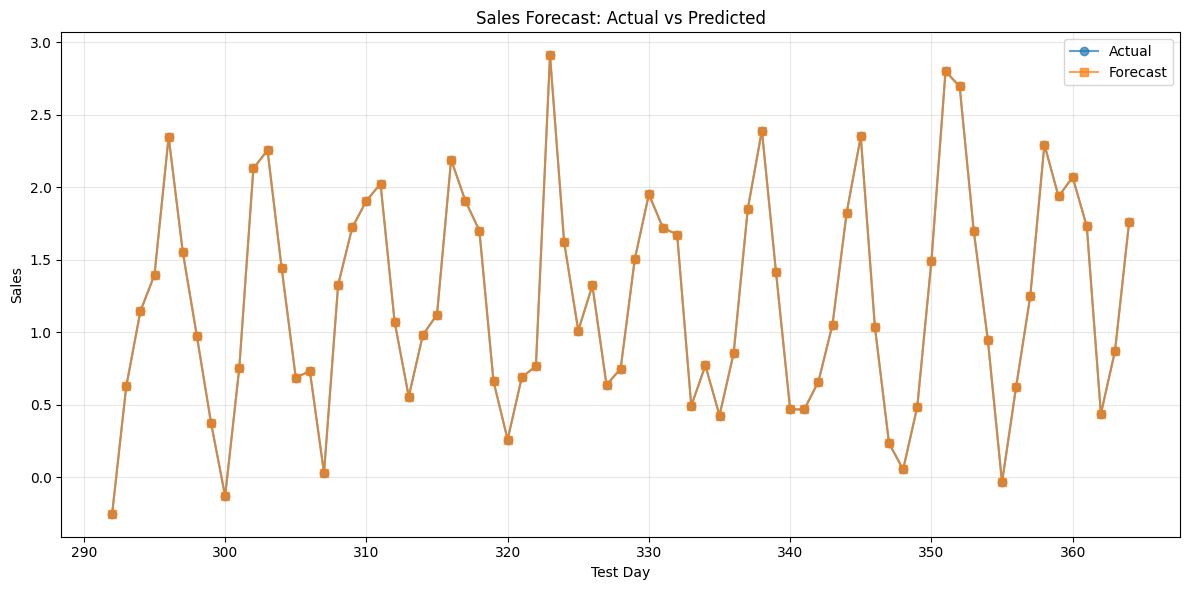


Forecast visualization complete!


In [65]:
# Visualize predictions vs actuals
import matplotlib.pyplot as plt

test_outputs = outputs[outputs['split'] == 'test']

plt.figure(figsize=(12, 6))
plt.plot(test_outputs.index, test_outputs['actuals'], label='Actual', marker='o', alpha=0.7)
plt.plot(test_outputs.index, test_outputs['forecast'], label='Forecast', marker='s', alpha=0.7)
plt.fill_between(
    test_outputs.index,
    test_outputs['actuals'],
    test_outputs['forecast'],
    alpha=0.2
)
plt.xlabel('Test Day')
plt.ylabel('Sales')
plt.title('Sales Forecast: Actual vs Predicted')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nForecast visualization complete!")

## Summary

This comprehensive demo covered all major capabilities of py-recipes:

1. **Basic Operations**: prep/bake pattern for preventing data leakage
2. **Time Series**: Lags, rolling windows, differencing, date features
3. **Feature Selection**: PCA, correlation, VIP, Boruta, RFE
4. **Transformations**: Log, sqrt, Box-Cox, Yeo-Johnson
5. **Scaling**: Center, scale, normalize, range
6. **Categorical**: Dummy, integer encoding, pooling, novel handling
7. **Imputation**: Mean, median, KNN, with NA indicators
8. **Basis Functions**: Polynomials, splines, harmonics
9. **Interactions**: Multiplicative interactions, ratios
10. **Discretization**: Binning, cutting
11. **Reduction**: ICA, Kernel PCA, PLS
12. **Selectors**: Flexible column selection
13. **Roles**: Column role management
14. **Workflows**: Seamless integration
15. **Real-World**: Complete sales forecasting example

### Key Takeaways

- **51 recipe steps** available across 14 categories
- **No data leakage**: All parameters fit on training data only
- **Composable**: Chain multiple steps in logical order
- **Reproducible**: Same transformations apply to new data
- **Integrated**: Works seamlessly with py-workflows and py-parsnip

### Next Steps

- Explore **py-tune** for hyperparameter optimization
- Use **py-workflowsets** for multi-model comparison
- Check out **py-yardstick** for additional metrics
- See the project documentation for more examples